In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

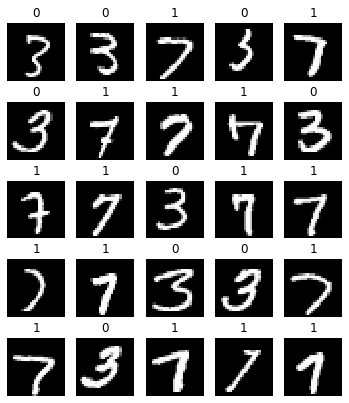

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [7]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

In [9]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [14]:
y

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0], dtype=int64)

# Итерация по эпохам

In [15]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [16]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.69104276, 0.35130898, 0.09860825, ..., 0.32923169, 0.46502192,
        0.95792131],
       [0.22491232, 0.38375809, 0.7482604 , ..., 0.89548545, 0.45618644,
        0.4239114 ],
       [0.71873826, 0.46563739, 0.98215084, ..., 0.91678264, 0.98305076,
        0.76466501],
       ...,
       [0.18271593, 0.98765115, 0.56484612, ..., 0.39779351, 0.44507181,
        0.00313623],
       [0.61515638, 0.71729922, 0.93623196, ..., 0.36293301, 0.47878314,
        0.98109271],
       [0.47962454, 0.85329664, 0.52742547, ..., 0.13638895, 0.85804094,
        0.86866708]])

In [17]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[ 0.10798653, -0.92267117, -2.3068768 , ..., -1.00260004,
        -0.54942534,  0.87462358],
       [-1.44145908, -0.81047262,  0.2698894 , ...,  0.69150488,
        -0.57674763, -0.67852994],
       [ 0.18632666, -0.54752989,  0.9466099 , ...,  0.75360554,
         0.94929427,  0.31639514],
       ...,
       [-1.66643753,  0.96302905, -0.2521508 , ..., -0.76358256,
        -0.61143072, -5.76472487],
       [-0.10746139,  0.18225598,  0.81063826, ..., -0.88181664,
        -0.50727422,  0.94345459],
       [-0.504712  ,  0.56946712, -0.36157009, ..., -1.97364263,
         0.58313079,  0.61378717]])

In [18]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [19]:
res

array([[124.63372004, 124.76530461, 133.07948531, ..., 122.91390957,
        131.70042556, 123.18716748],
       [126.44069604, 127.93314443, 132.80275662, ..., 124.84905889,
        132.89490211, 126.51429902],
       [134.63735589, 136.16864974, 135.88543301, ..., 127.12611401,
        132.34187919, 131.52726988],
       ...,
       [123.68124732, 123.81527458, 128.99945128, ..., 124.25648739,
        127.43958168, 123.81448139],
       [129.15774717, 131.58432441, 134.86400696, ..., 129.32136906,
        133.53718278, 130.30891244],
       [135.83193838, 140.26103071, 140.98750587, ..., 134.06613534,
        134.47166145, 133.25021376]])

In [20]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [21]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [22]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """
        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):
        pass

# Тестирование

In [23]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [24]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [25]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [26]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [27]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features)
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None
        
        self._x = None
        self._linear_result = None

    def forward(self, x):
        self._x = np.copy(x)
        self._linear_result = np.dot(self._x, self.weight) + self.bias
        return self._linear_result

    def backward(self, grad):
        self._grad_weight = np.dot(self._x.T, grad)
        self._grad_bias = np.dot(np.ones((self._x.shape[0])), grad)
        return np.dot(grad, self.weight.T)

    def step(self, learning_rate):
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

# Тестирование

In [28]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [29]:
linear = Linear(in_features=4, out_features=3)

In [30]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [31]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [32]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [33]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [34]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [35]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [36]:
class ReLU:

    def __init__(self):
        self._relu_result = None

    def forward(self, x):
        self._relu_result = np.maximum(x, 0)
        return self._relu_result

    def backward(self, prev_grad):
        grad = np.copy(prev_grad)
        grad[self._relu_result == 0] = 0
        return grad

    def step(self, learning_rate):
        pass

# Тестирование

In [37]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [38]:
relu = ReLU()

In [39]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [40]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [41]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [42]:
class BCELoss:
    def __init__(self):
        self._y_hat = None
        self._y = None
        self._bce_result = None
    
    def forward(self, y_hat, y):
        self._y_hat = np.copy(y_hat)
        self._y = np.expand_dims(y, 1)
        self._bce_result = -1 / self._y_hat.shape[0] * np.sum(self._y.T.dot(np.log(self._y_hat)) + (1 - self._y).T.dot(np.log(1 - self._y_hat)))
        return self._bce_result

    def backward(self):
        return 1 / self._y_hat.shape[0] * (-(self._y / self._y_hat) + (1 - self._y) / (1 - self._y_hat))

    def step(self, learning_rate):
        pass

# Тестирование

In [43]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [44]:
loss = BCELoss()

In [45]:
forward = loss.forward(x, y)
backward = loss.backward()

In [46]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [47]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [48]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules

    def forward(self, x):
        forward = np.copy(x)
        for module in self.modules:
            forward = module.forward(forward)
        return forward

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in self.modules[::-1]:
            grad = module.backward(grad)

    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

## Реализуйте обертку над моделью

In [49]:
class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        prediction = self.model.forward(x)
        loss_batch = self.loss.forward(prediction, y)
        grad = self.loss.backward()
        self.model.backward(grad)
        self.model.step(self.learning_rate)
        
        return loss_batch, prediction

In [50]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 10

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([Linear(784, 128), ReLU(), Linear(128, 1), Sigmoid()])

loss = BCELoss()

In [51]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Обучение модели

In [52]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 10: 100%|█████████████████████████████████████████████| 97/97 [00:09<00:00, 10.34it/s, loss=0.0536, metric=0.983]


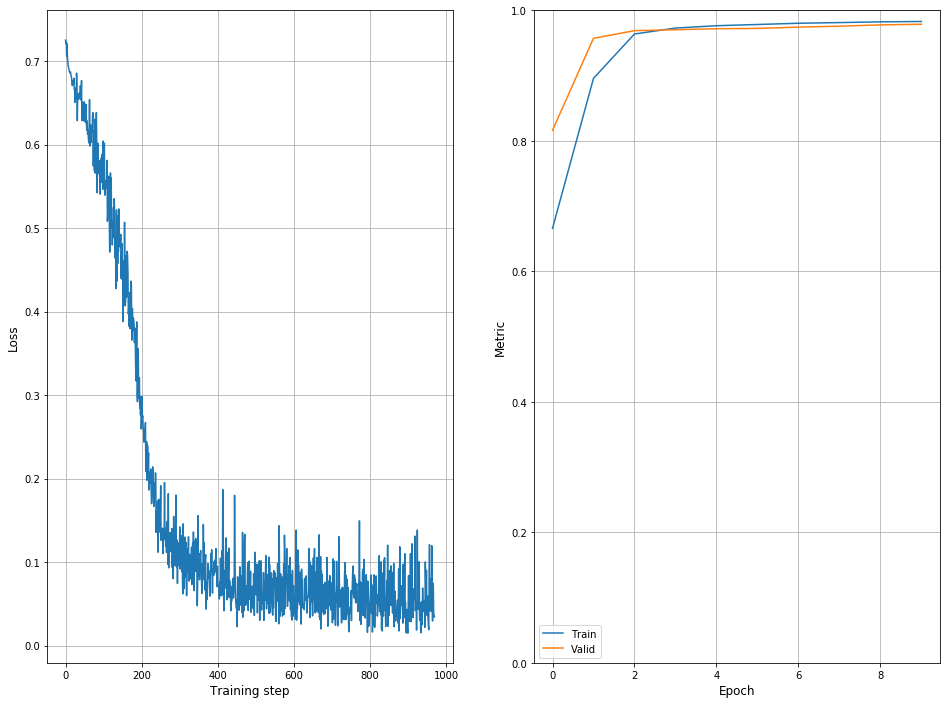

In [53]:
classifier.plot()